In [ ]:
import torch
import torchvision
import cv2x
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
from scipy.optimize import linear_sum_assignment
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [7]:
class MOT17Dataset(Dataset):
    def __init__(self, root_dir, split="train", max_size=800, use_gt=True):
        self.root_dir = root_dir
        self.split = split
        self.max_size = max_size  # Resize images to a maximum dimension
        self.use_gt = use_gt  # Use ground truth for training
        self.imgs = []
        self.annotations = []
        sequences = sorted(os.listdir(os.path.join(root_dir, split)))
        
        # Preload annotations to avoid repeated file I/O
        print(f"Loading {split} annotations...")
        for seq in sequences:
            if "FRCNN" not in seq:
                continue
            img_dir = os.path.join(root_dir, split, seq, "img1")
            
            # Choose between ground truth (for training) and detections (for testing)
            if use_gt and split == "train":
                ann_file = os.path.join(root_dir, split, seq, "gt/gt.txt")
            else:
                ann_file = os.path.join(root_dir, split, seq, "det/det.txt")
            
            img_files = sorted(os.listdir(img_dir))
            
            # Load sequence info
            seqinfo_path = os.path.join(root_dir, split, seq, "seqinfo.ini")
            seq_width, seq_height = 1920, 1080  # Default values
            if os.path.exists(seqinfo_path):
                with open(seqinfo_path, "r") as f:
                    lines = f.readlines()
                    for line in lines:
                        if "imWidth" in line:
                            seq_width = int(line.split("=")[1].strip())
                        elif "imHeight" in line:
                            seq_height = int(line.split("=")[1].strip())
            
            if os.path.exists(ann_file):
                with open(ann_file, "r") as f:
                    annotations = [line.strip().split(",") for line in f.readlines()]
                frame_dets = {}
                for ann in annotations:
                    frame_id = int(ann[0])
                    if frame_id not in frame_dets:
                        frame_dets[frame_id] = []
                    
                    if use_gt and split == "train":
                        # gt.txt format: frame_id, track_id, x, y, width, height, flag, class, visibility
                        # Convert to [x1, y1, x2, y2] format
                        x, y, w, h = float(ann[2]), float(ann[3]), float(ann[4]), float(ann[5])
                        if int(ann[6]) == 1:  # Only use objects marked as visible
                            box = [x, y, x + w, y + h]
                            frame_dets[frame_id].append({"box": box, "label": 1})  # Label 1 for pedestrian
                    else:
                        # det.txt format: frame_id, -1, x, y, width, height, confidence, -1, -1, -1
                        x, y, w, h = float(ann[2]), float(ann[3]), float(ann[4]), float(ann[5])
                        score = float(ann[6])
                        if score > 0.0:  # Filter low confidence detections
                            box = [x, y, x + w, y + h]
                            frame_dets[frame_id].append({"box": box, "label": 1, "score": score})
                
                for img_file in img_files:
                    frame_id = int(img_file.split(".")[0])
                    if frame_id in frame_dets:
                        self.imgs.append(os.path.join(img_dir, img_file))
                        self.annotations.append(frame_dets[frame_id])
            
        print(f"Loaded {len(self.imgs)} images for {split} split.")

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image to a smaller size
        h, w = img.shape[:2]
        scale = self.max_size / max(h, w)
        if scale < 1:  # Only resize if image is larger than max_size
            new_h, new_w = int(h * scale), int(w * scale)
            img = cv2.resize(img, (new_w, new_h))
        
        annotations = self.annotations[idx]
        boxes = [ann["box"] for ann in annotations]
        # Scale bounding boxes
        boxes = [[box[0] * scale, box[1] * scale, box[2] * scale, box[3] * scale] for box in boxes]
        labels = [ann["label"] for ann in annotations]
        
        img = F.to_tensor(img)
        target = {"boxes": torch.tensor(boxes, dtype=torch.float32),
                  "labels": torch.tensor(labels, dtype=torch.int64),
                  "image_id": torch.tensor([idx])}
        return img, target

Loading train annotations...
Loaded 5316 images for train split.
Dataset size: 5316 images


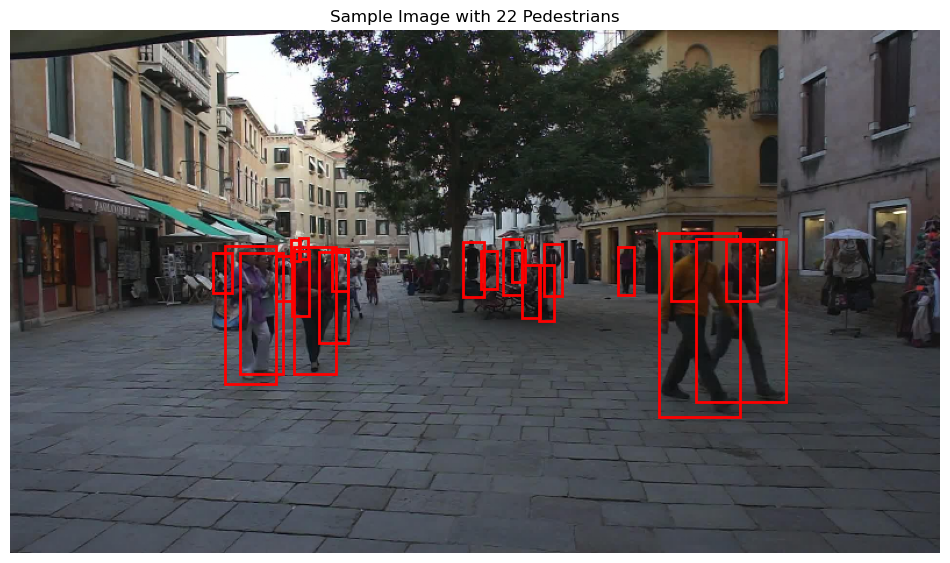

Batch size: 2
Image shape: torch.Size([3, 450, 800])
Number of objects in first image: 13


In [8]:
# Setup dataset path
root_dir = "/home/dc_gr1/Project/MOT17/MOT17"

# Create training dataset
train_dataset = MOT17Dataset(
    root_dir=root_dir, 
    split="train", 
    max_size=800,
    use_gt=True
)

# Display some statistics
print(f"Dataset size: {len(train_dataset)} images")

# Display a sample image with bounding boxes
idx = 0  # First image
img_tensor, target = train_dataset[idx]

# Convert tensor back to numpy for display
img_np = img_tensor.permute(1, 2, 0).numpy()
boxes = target["boxes"].numpy()

plt.figure(figsize=(12, 8))
plt.imshow(img_np)

# Draw bounding boxes
for box in boxes:
    x1, y1, x2, y2 = box
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                     fill=False, edgecolor='red', linewidth=2))

plt.axis('off')
plt.title(f"Sample Image with {len(boxes)} Pedestrians")
plt.show()

# Create DataLoader
train_loader = DataLoader(
    train_dataset, 
    batch_size=2,  # Small batch size due to memory constraints
    shuffle=True, 
    num_workers=4, 
    pin_memory=True, 
    collate_fn=lambda x: tuple(zip(*x))
)

# Show batch information
for imgs, targets in train_loader:
    print(f"Batch size: {len(imgs)}")
    print(f"Image shape: {imgs[0].shape}")
    print(f"Number of objects in first image: {len(targets[0]['boxes'])}")
    break

In [9]:
def get_faster_rcnn_model(num_classes=2, freeze_backbone=False):
    # Use pre-trained Faster R-CNN with ResNet-50 FPN backbone
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    
    # Freeze backbone if specified (optional)
    if freeze_backbone:
        for param in model.backbone.parameters():
            param.requires_grad = False
    
    # Replace the classifier head for MOT17 (2 classes: background, pedestrian)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    
    return model

# Create model instance
model = get_faster_rcnn_model(num_classes=2, freeze_backbone=False)
model = model.to(device)

# Display model summary
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created: Faster R-CNN with ResNet-50 FPN backbone")
print(f"Total parameters: {num_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model created: Faster R-CNN with ResNet-50 FPN backbone
Total parameters: 41,299,161
Trainable parameters: 41,076,761


In [11]:
def train_model(model, train_loader, model_path="10models/faster_rcnn_mot17.pt", num_epochs=1):
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=1e-4)
    scaler = GradScaler()  # For mixed precision training
    
    # Create directory for model if it doesn't exist
    model_dir = os.path.dirname(model_path)
    os.makedirs(model_dir, exist_ok=True)
    
    # Get base filename without extension for epoch-specific saving
    base_name = os.path.splitext(os.path.basename(model_path))[0]
    
    # For tracking metrics
    loss_history = []
    
    print(f"Starting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for imgs, targets in progress_bar:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            with autocast():  # Mixed precision
                loss_dict = model(imgs, targets)
                losses = sum(loss for loss in loss_dict.values())
            
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
            
            batch_loss = losses.item()
            epoch_loss += batch_loss
            progress_bar.set_postfix({"batch_loss": f"{batch_loss:.4f}"})
            
        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}, Train Loss: {avg_epoch_loss:.4f}")
        
        # Save model after each epoch with epoch number in filename
        epoch_model_path = os.path.join(model_dir, f"{base_name}_epoch{epoch+1}.pt")
        torch.save(model.state_dict(), epoch_model_path)
        print(f"Model checkpoint saved as '{epoch_model_path}'")
    
    # Save final model with original filename
    torch.save(model.state_dict(), model_path)
    print(f"Final model saved as '{model_path}'")
    
    # Plot loss history
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    return model

Starting training for 10 epochs...


Epoch 1/10: 100%|██████████| 2658/2658 [17:14<00:00,  2.57it/s, batch_loss=0.3528]


Epoch 1, Train Loss: 0.5202
Model checkpoint saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model_epoch1.pt'


Epoch 2/10: 100%|██████████| 2658/2658 [17:16<00:00,  2.57it/s, batch_loss=0.4605]


Epoch 2, Train Loss: 0.3769
Model checkpoint saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model_epoch2.pt'


Epoch 3/10: 100%|██████████| 2658/2658 [17:10<00:00,  2.58it/s, batch_loss=0.1958]


Epoch 3, Train Loss: 0.3111
Model checkpoint saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model_epoch3.pt'


Epoch 4/10: 100%|██████████| 2658/2658 [17:08<00:00,  2.59it/s, batch_loss=0.3033]


Epoch 4, Train Loss: 0.2753
Model checkpoint saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model_epoch4.pt'


Epoch 5/10: 100%|██████████| 2658/2658 [17:08<00:00,  2.58it/s, batch_loss=0.2227]


Epoch 5, Train Loss: 0.2468
Model checkpoint saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model_epoch5.pt'


Epoch 6/10: 100%|██████████| 2658/2658 [17:09<00:00,  2.58it/s, batch_loss=0.1227]


Epoch 6, Train Loss: 0.2217
Model checkpoint saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model_epoch6.pt'


Epoch 7/10: 100%|██████████| 2658/2658 [17:08<00:00,  2.58it/s, batch_loss=0.1319]


Epoch 7, Train Loss: 0.2034
Model checkpoint saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model_epoch7.pt'


Epoch 8/10: 100%|██████████| 2658/2658 [17:08<00:00,  2.58it/s, batch_loss=0.2520]


Epoch 8, Train Loss: 0.1899
Model checkpoint saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model_epoch8.pt'


Epoch 9/10: 100%|██████████| 2658/2658 [17:04<00:00,  2.60it/s, batch_loss=0.1934]


Epoch 9, Train Loss: 0.1791
Model checkpoint saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model_epoch9.pt'


Epoch 10/10: 100%|██████████| 2658/2658 [17:08<00:00,  2.58it/s, batch_loss=0.2101]


Epoch 10, Train Loss: 0.1712
Model checkpoint saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model_epoch10.pt'
Final model saved as '/home/dc_gr1/Project/10models/10epoch_rcnn_model.pt'


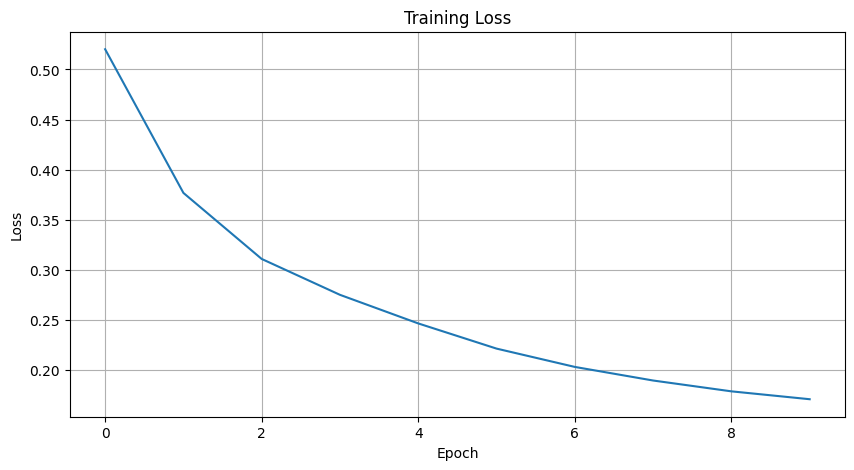

In [ ]:
# Set training parameters
model_path = "/home/dc_gr1/Project/10models/10epoch_rcnn_model.pt"
num_epochs = 10 # Can increase for better performance

# Train the model
trained_model = train_model(
    model=model, 
    train_loader=train_loader,
    model_path=model_path,
    num_epochs=num_epochs
)

In [12]:
class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = cv2.KalmanFilter(7, 4)
        self.kf.measurementMatrix = np.array([[1, 0, 0, 0, 0, 0, 0],
                                              [0, 1, 0, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0, 0]], np.float32)
        self.kf.transitionMatrix = np.array([[1, 0, 0, 0, 1, 0, 0],
                                             [0, 1, 0, 0, 0, 1, 0],
                                             [0, 0, 1, 0, 0, 0, 1],
                                             [0, 0, 0, 1, 0, 0, 0],
                                             [0, 0, 0, 0, 1, 0, 0],
                                             [0, 0, 0, 0, 0, 1, 0],
                                             [0, 0, 0, 0, 0, 0, 1]], np.float32)
        self.kf.processNoiseCov = np.eye(7, dtype=np.float32) * 0.03
        self.kf.statePre = np.array([bbox[0], bbox[1], bbox[2], bbox[3], 0, 0, 0], np.float32)
        self.id = np.random.randint(10000)
        self.time_since_update = 0
        self.hits = 0
    
    def predict(self):
        pred = self.kf.predict()
        self.time_since_update += 1
        return pred[:4]
    
    def update(self, bbox):
        self.kf.correct(np.array(bbox, np.float32))
        self.time_since_update = 0
        self.hits += 1

class SORT:
    def __init__(self, max_age=1, min_hits=3, iou_threshold=0.3):
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_threshold = iou_threshold
        self.trackers = []
        self.frame_count = 0
    
    def iou(self, bb1, bb2):
        x1, y1, x2, y2 = bb1
        x1_, y1_, x2_, y2_ = bb2
        xi1, yi1 = max(x1, x1_), max(y1, y1_)
        xi2, yi2 = min(x2, x2_), min(y2, y2_)
        inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
        box1_area = (x2 - x1) * (y2 - y1)
        box2_area = (x2_ - x1_) * (y2_ - y1_)
        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area if union_area > 0 else 0

    def update(self, detections):
        self.frame_count += 1
        trks = [t.predict() for t in self.trackers]
        matched, unmatched_dets, unmatched_trks = [], [], list(range(len(trks)))
        
        if len(trks) > 0 and len(detections) > 0:
            iou_matrix = np.array([[self.iou(det, trk) for trk in trks] for det in detections])
            row_ind, col_ind = linear_sum_assignment(-iou_matrix)
            for r, c in zip(row_ind, col_ind):
                if iou_matrix[r, c] >= self.iou_threshold:
                    matched.append((r, c))
                    unmatched_trks.remove(c)
                else:
                    unmatched_dets.append(r)
            unmatched_dets = [i for i in range(len(detections)) if i not in [m[0] for m in matched]]
        
        for i in unmatched_dets:
            self.trackers.append(KalmanBoxTracker(detections[i]))
        
        for i in reversed(unmatched_trks):
            self.trackers[i].time_since_update += 1
            if self.trackers[i].time_since_update > self.max_age:
                self.trackers.pop(i)
        
        for r, c in matched:
            self.trackers[c].update(detections[r])
        
        return [(t.id, t.predict()) for t in self.trackers if t.hits >= self.min_hits or self.frame_count <= self.min_hits]

In [13]:
import os
# Check if trained model exists
model_path = "/home/dc_gr1/Project/10models/10epoch_rcnn_model.pt"
if os.path.exists(model_path):
    print(f"Loading trained model from {model_path}")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"No trained model found at {model_path}, using freshly trained model")

Loading trained model from /home/dc_gr1/Project/10models/10epoch_rcnn_model.pt


In [16]:
def detect_objects(model, image_path, conf_threshold=0.5, max_size=800):
    # Load and prepare image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize for model input
    h, w = img_rgb.shape[:2]
    scale = max_size / max(h, w)
    if scale < 1:
        new_h, new_w = int(h * scale), int(w * scale)
        input_img = cv2.resize(img_rgb, (new_w, new_h))
    else:
        input_img = img_rgb
        scale = 1.0
    
    # Convert to tensor
    img_tensor = F.to_tensor(input_img).unsqueeze(0).to(device)
    
    # Run inference
    with torch.no_grad():
        predictions = model(img_tensor)[0]
    
    # Process predictions
    boxes = predictions["boxes"].cpu().numpy()
    scores = predictions["scores"].cpu().numpy()
    labels = predictions["labels"].cpu().numpy()
    
    # Scale boxes back to original size
    if scale < 1:
        boxes = boxes / scale
    
    # Filter by confidence and class (only pedestrians)
    mask = (scores > conf_threshold) & (labels == 1)
    filtered_boxes = boxes[mask]
    filtered_scores = scores[mask]
    
    return img_rgb, filtered_boxes, filtered_scores

# Function to visualize detections
def visualize_detections(img_rgb, boxes, scores=None):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_rgb)
    
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
        if scores is not None:
            score = scores[i]
            ax.text(x1, y1-10, f"{score:.2f}", fontsize=12, color='white',
                    bbox=dict(facecolor='red', alpha=0.7))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
# Tracking Function
def track_video(model_path, video_dir, output_path, device="cuda", conf_threshold=0.5):
    # Load the trained model
    model = get_faster_rcnn_model(num_classes=2)
    
    if model_path:
        print(f"Loading model from {model_path}")
        model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Initialize tracker
    tracker = SORT(max_age=15, min_hits=2, iou_threshold=0.3)  # Adjusted parameters for better tracking
    imgs = sorted(os.listdir(video_dir))
    
    # Get video dimensions from first frame
    first_img = cv2.imread(os.path.join(video_dir, imgs[0]))
    h, w = first_img.shape[:2]
    
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    cap = cv2.VideoWriter(output_path, fourcc, 30, (w, h))
    
    # Add counters for debugging
    total_frames = len(imgs)
    frames_with_detections = 0
    frames_with_tracks = 0
    
    print(f"Processing {len(imgs)} frames...")
    for img_file in tqdm(imgs):
        img_path = os.path.join(video_dir, img_file)
        img = cv2.imread(img_path)
        original_img = img.copy()  # Keep original for display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize for model input
        h, w = img_rgb.shape[:2]
        max_size = 800
        scale = max_size / max(h, w)
        if scale < 1:
            new_h, new_w = int(h * scale), int(w * scale)
            input_img = cv2.resize(img_rgb, (new_w, new_h))
        else:
            input_img = img_rgb
            scale = 1.0
        
        img_tensor = F.to_tensor(input_img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            preds = model(img_tensor)[0]
            
        boxes = preds["boxes"].cpu().numpy()
        scores = preds["scores"].cpu().numpy()
        labels = preds["labels"].cpu().numpy()
        
        # Debug: print raw detections
        print(f"Frame {img_file}: {len(boxes)} raw detections")
        
        # Scale boxes back to original image size
        if scale < 1:
            boxes = boxes / scale
            
        # Filter by confidence and class (only pedestrians)
        mask = (scores > conf_threshold) & (labels == 1)
        filtered_boxes = boxes[mask]
        
        # Debug: print filtered detections
        print(f"Frame {img_file}: {len(filtered_boxes)} filtered detections (conf > {conf_threshold})")
        
        if len(filtered_boxes) > 0:
            frames_with_detections += 1
        
        # Try a lower confidence threshold if no detections
        if len(filtered_boxes) == 0 and len(boxes) > 0:
            # Backup approach with lower threshold
            lower_threshold = 0.3
            mask = (scores > lower_threshold) & (labels == 1)
            filtered_boxes = boxes[mask]
            print(f"Trying lower threshold {lower_threshold}: {len(filtered_boxes)} detections")
        
        # Update tracker
        tracks = tracker.update(filtered_boxes)
        
        # Debug: print tracks
        print(f"Frame {img_file}: {len(tracks)} tracks")
        
        if len(tracks) > 0:
            frames_with_tracks += 1
        
        # Draw tracks on the original image
        for track_id, bbox in tracks:
            x1, y1, x2, y2 = map(int, bbox)
            # Draw bounding box
            cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw ID
            cv2.putText(original_img, f"ID: {int(track_id)}", (x1, y1-10),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        # Write frame to output video
        cap.write(original_img)
        
        # Save sample frames with detections for debugging
        if len(tracks) > 0 and frames_with_tracks <= 5:  # Save first 5 frames with tracks
            debug_path = os.path.join(os.path.dirname(output_path), f"debug_frame_{img_file}")
            cv2.imwrite(debug_path, original_img)
            print(f"Saved debug frame to {debug_path}")
    
    cap.release()
    print(f"Tracking completed. Output video saved to {output_path}")
    print(f"Summary: {frames_with_detections}/{total_frames} frames had detections")
    print(f"Summary: {frames_with_tracks}/{total_frames} frames had tracks")
    
    return frames_with_detections, frames_with_tracks, total_frames

In [ ]:
from IPython.display import Video, display, HTML
import os
import tempfile
import shutil
import cv2
from tqdm.notebook import tqdm

# Function to process a video file by path
def process_video_file(video_path, output_dir="/home/dc_gr1/Project/results", verbose=False):
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return
        
    filename = os.path.basename(video_path)
    print(f"Processing video file: {filename}")
    
    # Create a temporary directory for video frames
    frames_dir = tempfile.mkdtemp()
    print(f"Created temporary directory for frames: {frames_dir}")
    
    # Extract frames from the video
    print("Extracting frames from video...")
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
        
    # Get total frames for progress bar
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0
    
    # Show progress bar for frame extraction
    pbar = tqdm(total=total_frames, desc="Extracting frames")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Save the frame
        frame_path = f"{frames_dir}/{frame_count:06d}.jpg"
        cv2.imwrite(frame_path, frame)
        frame_count += 1
        pbar.update(1)
    
    cap.release()
    pbar.close()
    print(f"Extracted {frame_count} frames from video.")
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/tracked_{filename}"
    
    # Set model path
    model_path = "/home/dc_gr1/Project/10models/10epoch_rcnn_model.pt"
    
    # Call the tracking function with verbosity control
    print(f"Starting video tracking... Output will be saved to: {output_path}")
    
    # Temporary solution to suppress stdout
    if not verbose:
        import sys
        import io
        
        # Redirect stdout to capture verbose output
        old_stdout = sys.stdout
        sys.stdout = io.StringIO()
    
    # Call tracking function
    try:
        frames_with_detections, frames_with_tracks, total_frames = track_video(
            model_path=model_path,
            video_dir=frames_dir,
            output_path=output_path,
            device=device,
            conf_threshold=0.5
        )
    finally:
        # Restore stdout
        if not verbose:
            sys.stdout = old_stdout
    
    # Display tracking statistics
    print(f"\nTracking Results:")
    print(f"- Total frames: {total_frames}")
    print(f"- Frames with detections: {frames_with_detections} ({frames_with_detections/total_frames*100:.1f}%)")
    print(f"- Frames with tracks: {frames_with_tracks} ({frames_with_tracks/total_frames*100:.1f}%)")
    
    # Verify the video was created
    if os.path.exists(output_path):
        file_size_mb = os.path.getsize(output_path) / (1024 * 1024)
        print(f"\nTrack"
              f"ed video saved successfully:")
        print(f"- File: {output_path}")
        print(f"- Size: {file_size_mb:.2f} MB")
        
        # Try to get video properties for additional information
        try:
            cap = cv2.VideoCapture(output_path)
            if cap.isOpened():
                width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                fps = cap.get(cv2.CAP_PROP_FPS)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                cap.release()
                print(f"- Resolution: {width}x{height}")
                print(f"- Frame rate: {fps} fps")
                print(f"- Duration: {frame_count/fps:.2f} seconds ({frame_count} frames)")
            else:
                print("Warning: Could not open output video to check properties")
        except Exception as e:
            print(f"Error checking video properties: {str(e)}")
    else:
        print(f"Error: Output video file was not created at {output_path}")
    
    # Clean up the temporary directory
    shutil.rmtree(frames_dir)
    print(f"Temporary directory {frames_dir} has been removed.")
    
    return output_path

# Example usage:
# Provide the path to your video file 
video_path = "/home/dc_gr1/Project/MOT17-13-SDP-raw.mp4"
output_dir = "/home/dc_gr1/Project/results"  # You can change this output directory
process_video_file(video_path, output_dir=output_dir, verbose=False)